# 23. Convolutional AutoEncoder

In [1]:
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 23.1 Preparing MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=500,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

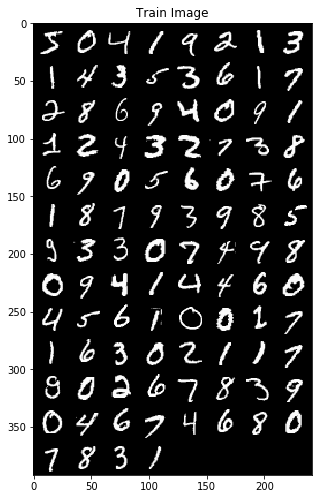

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 23.2 Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*3*3, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        z = self.fc(z.view(-1, 64*3*3))
        
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Linear(300, 64*3*3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        z = self.fc(z)
        out = self.decoder(z.view(-1, 64, 3, 3))
        
        return out

In [9]:
E = Encoder().cuda()
D = Decoder().cuda()

## 22.3 Model Training

In [10]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [11]:
num_epochs = 10

In [12]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        pre = D(E(X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [100/600], Loss: 0.0477
Epoch [1/10], lter [200/600], Loss: 0.0425
Epoch [1/10], lter [300/600], Loss: 0.0312
Epoch [1/10], lter [400/600], Loss: 0.0263
Epoch [1/10], lter [500/600], Loss: 0.0249
Epoch [1/10], lter [600/600], Loss: 0.0277
Epoch [2/10], lter [100/600], Loss: 0.0201
Epoch [2/10], lter [200/600], Loss: 0.0233
Epoch [2/10], lter [300/600], Loss: 0.0210
Epoch [2/10], lter [400/600], Loss: 0.0197
Epoch [2/10], lter [500/600], Loss: 0.0189
Epoch [2/10], lter [600/600], Loss: 0.0234
Epoch [3/10], lter [100/600], Loss: 0.0167
Epoch [3/10], lter [200/600], Loss: 0.0190
Epoch [3/10], lter [300/600], Loss: 0.0178
Epoch [3/10], lter [400/600], Loss: 0.0172
Epoch [3/10], lter [500/600], Loss: 0.0167
Epoch [3/10], lter [600/600], Loss: 0.0210
Epoch [4/10], lter [100/600], Loss: 0.0149
Epoch [4/10], lter [200/600], Loss: 0.0174
Epoch [4/10], lter [300/600], Loss: 0.0165
Epoch [4/10], lter [400/600], Loss: 0.0160
Epoch [4/10], lter [500/600], Loss: 0.0155
Epoch [4/10

## 22.4 Test Model

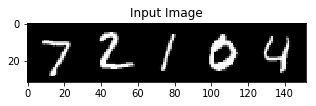

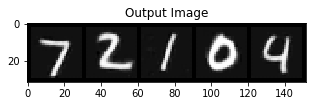

In [13]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    imshow(torchvision.utils.make_grid(images[:5], normalize=True), "Input Image")
    
    images = images.cuda()
    outputs = D(E(images))
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu()[:5], normalize=True), "Output Image")
    
    break

## 22.5 Latent Space Analysis

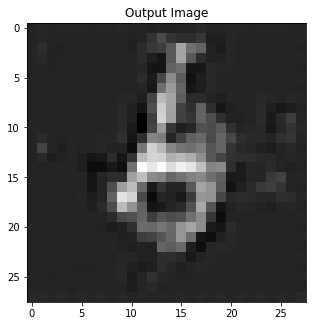

In [14]:
z = torch.rand(E(images).size()).cuda()
outputs = D(z)
imshow(torchvision.utils.make_grid(outputs.data.cpu()[0], normalize=True), "Output Image")

In [15]:
test_data, test_label = iter(test_loader).next()

In [16]:
latent_vectors = E(test_data.cuda())
latent_labels = test_label

In [17]:
latent_vectors.shape

torch.Size([500, 10])

In [18]:
latent_labels.shape

torch.Size([500])

### - PCA

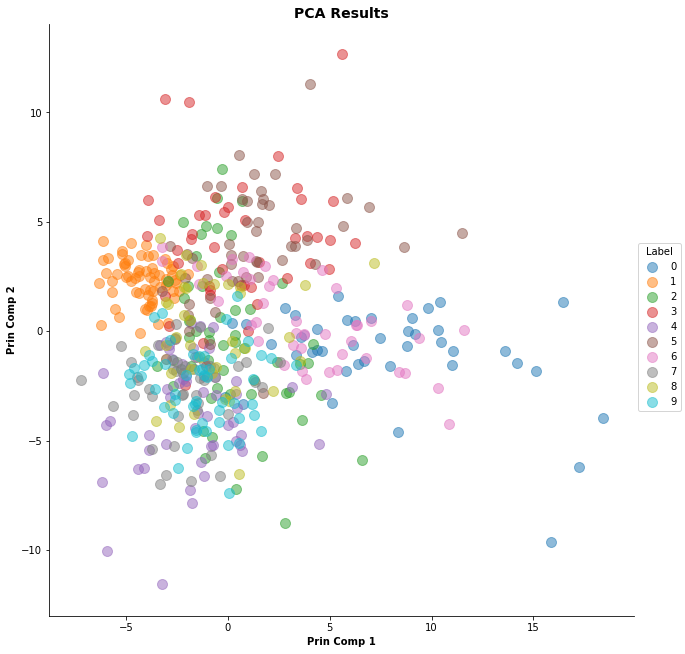

In [19]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_vectors.data.cpu().numpy())
pca_result = pd.DataFrame(pca_result, columns = ['PC1', 'PC2'])
pca_result['Label'] = pd.DataFrame(latent_labels.data.cpu().numpy()).astype(int)

# Create scatterplot of dataframe
sns.lmplot(x='PC1',
           y='PC2',
           data=pca_result,
           fit_reg=False,
           legend=True,
           size=9,
           hue='Label',
           scatter_kws={"s":100, "alpha":0.5})

plt.title('PCA Results', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

### - tSNE

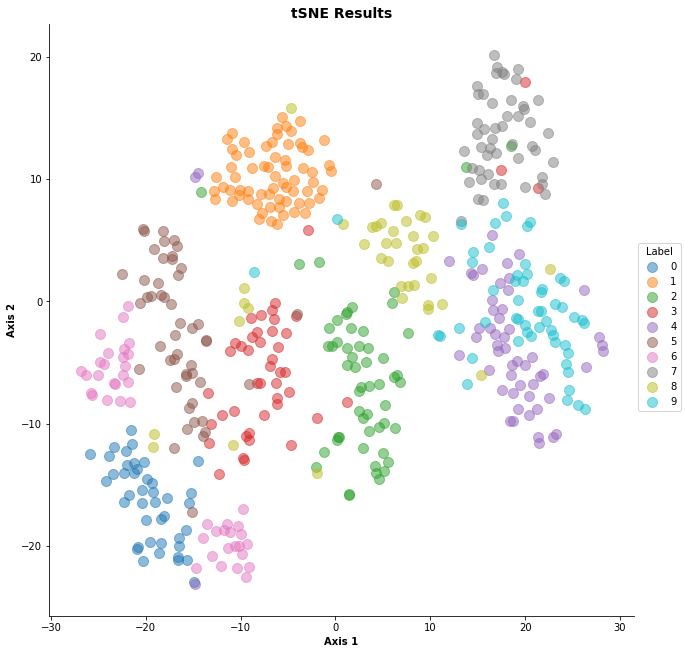

In [20]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(latent_vectors.data.cpu().numpy())
tsne_result = pd.DataFrame(tsne_result, columns = ['Axis1', 'Axis2'])
tsne_result['Label'] = pd.DataFrame(latent_labels.data.cpu().numpy()).astype(int)

# Create scatterplot of dataframe
sns.lmplot(x='Axis1',
           y='Axis2',
           data=tsne_result,
           fit_reg=False,
           legend=True,
           size=9,
           hue='Label',
           scatter_kws={"s":100, "alpha":0.5})

plt.title('tSNE Results', weight='bold').set_fontsize('14')
plt.xlabel('Axis 1', weight='bold').set_fontsize('10')
plt.ylabel('Axis 2', weight='bold').set_fontsize('10')